In [1]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image
from albumentations import pytorch as AT
import albumentations as A
import torchvision.datasets as dataset
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import natsort
!pip install -U skorch
%matplotlib inline
import time

Requirement already up-to-date: skorch in /usr/local/lib/python3.7/dist-packages (0.9.0)


In [2]:
!nvidia-smi

Sun Mar 21 11:26:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.callbacks import LRScheduler, Checkpoint 
from skorch.callbacks import Freezer, EarlyStopping

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# for multiprocessing
import multiprocessing as mp


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir='/content/drive/MyDrive/dataset/dataset'
image_label='/content/drive/MyDrive/last_labels.csv'
train_files=os.listdir(train_dir)
labels=pd.read_csv(image_label)

In [6]:
len(train_files)

1552

In [7]:
labels['class'].value_counts()

9     145
10    136
3     132
12    126
8     126
6     120
4     120
2     120
0     120
11    112
7     108
5      96
1      91
Name: class, dtype: int64

In [8]:
labels

,image,class
0,500,0
1,500_0,0
2,500_1,0
3,500_2,0
4,501,0
...,...,...
1547,79_0,12
1548,79_1,12
1549,79_2,12
1550,79_3,12


In [7]:
import multiprocessing


In [8]:
batch_size = 20
num_workers = multiprocessing.cpu_count()
img_size=96

In [9]:
data_transforms = A.Compose([
    A.Resize(96, 96),                         
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    A.augmentations.transforms.Transpose(p=0.5),
    A.augmentations.transforms.ShiftScaleRotate(p=0.5),
    A.augmentations.transforms.VerticalFlip(p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.5),
    A.augmentations.transforms.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    #A.Crop(x_min=int(3*img_size/10),x_max=int(7*img_size/10),y_min=int(*img_size/10),y_max=int(6*img_size/10)),
    #A.Normalize((2.7176417e-05, -0.00011741407, -0.0004583559), (0.0038161594, 0.003801249, 0.0035198121))
    A.Normalize(),
    AT.ToTensor()
    ])

data_transforms_test = A.Compose([
    A.Resize(96, 96),
     A.Normalize(),
    AT.ToTensor()
    ])

In [10]:
trainset = DatasetRetriever(train_dir, train_files,labels, transform = data_transforms)
#testset = DatasetRetriever(test_dir, test_files,image_label,transform=data_transforms_test, mode = "test")

In [14]:
len(trainset)

1552

In [11]:
valid_size = int(len(train_files) * 0.2)
trainset, validset = random_split(trainset, 
                                  (len(train_files)-valid_size, valid_size))


In [12]:

trainloader = torch.utils.data.DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=True)

'''
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         num_workers = num_workers)'''

'\ntestloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,\n                                         num_workers = num_workers)'

In [17]:
samples,files = next(iter(validloader))

In [19]:
files

tensor([12,  7,  8,  4, 11,  1, 11,  1,  8, 10,  3,  9, 10,  2,  3,  3,  4, 10,
         0,  4])

In [ ]:
'''mean0=[]
mean1=[]
mean2=[]
std1=[]
std2=[]
std3=[]

for i in range(449):
  mean0.append(samples[i,0,:,:].mean())
  mean1.append(samples[i,1,:,:].mean())
  mean2.append(samples[i,2,:,:].mean())
  std1.append(samples[i,0,:,:].std())
  std2.append(samples[i,1,:,:].std())
  std3.append(samples[i,2,:,:].std())

print((np.mean(mean0),np.mean(mean1),np.mean(mean2)),(np.mean(std1),np.mean(std2),np.mean(std3)))'''

'mean0=[]\nmean1=[]\nmean2=[]\nstd1=[]\nstd2=[]\nstd3=[]\n\nfor i in range(449):\n  mean0.append(samples[i,0,:,:].mean())\n  mean1.append(samples[i,1,:,:].mean())\n  mean2.append(samples[i,2,:,:].mean())\n  std1.append(samples[i,0,:,:].std())\n  std2.append(samples[i,1,:,:].std())\n  std3.append(samples[i,2,:,:].std())\n\nprint((np.mean(mean0),np.mean(mean1),np.mean(mean2)),(np.mean(std1),np.mean(std2),np.mean(std3)))'

In [18]:
model = torchvision.models.mobilenet_v2(pretrained=True,progress=True)

In [19]:
in_features = model.classifier[1].in_features
model.classifier[1]=nn.Linear(in_features, 13)

In [30]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [31]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, sheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 20
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
          print(time.ctime(), 'Epoch:', epoch)
          b_i=0
          train_loss = []

          for batch_i, (data, target) in enumerate(train_loader):
              b_i+=1
              data, target = data.to(device), target.to(device)
              optimizer.zero_grad()
              output = model_conv(data)
              loss = criterion(output, target)
              train_loss.append(loss.item())
              loss.backward()
              optimizer.step()
              if b_i % 10 == 0: 
                  print(b_i)
      # запускаем валидацию
          model_conv.eval()
          val_loss = []
          for batch_i, (data, target) in enumerate(valid_loader):
              data, target = data.to(device), target.to(device)
              output = model_conv(data)
              loss = criterion(output, target)
              val_loss.append(loss.item()) 

          print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, lr: {optimizer.param_groups[0]['lr']}")

          valid_loss = np.mean(val_loss)
          sheduler.step(valid_loss)
          if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              torch.save(model_conv.state_dict(), '/content/drive/MyDrive/chess_weights/model_1.pt')
              
              valid_loss_min = valid_loss
              p = 0

          # проверяем как дела на валидации
          if valid_loss > valid_loss_min:
              p += 1
              
              print(f'{p} epochs of increasing val loss')
              if p > patience:
                  print('Stopping training')
                  stop = True
                  break        

          if stop:
              break

        
    return model_conv, train_loss, val_loss

In [32]:
torch.cuda.is_available()

True

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)#,momentum=0.9,nesterov=True,lr=0.1)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00025,momentum=0.9,nesterov=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [35]:
model_mob, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler, n_epochs=400)

Sun Mar 21 10:31:58 2021 Epoch: 1
10
20
30
40
50
60
Epoch 1, train loss: 1.1346, valid loss: 0.7476, lr: 0.001
Validation loss decreased (inf --> 0.747617).  Saving model ...
Sun Mar 21 10:41:31 2021 Epoch: 2
10
20
30
40
50
60
Epoch 2, train loss: 2.6539, valid loss: 2.6109, lr: 0.001
1 epochs of increasing val loss
Sun Mar 21 10:41:38 2021 Epoch: 3
10
20
30
40
50
60
Epoch 3, train loss: 2.5740, valid loss: 2.5926, lr: 0.001
2 epochs of increasing val loss
Sun Mar 21 10:41:44 2021 Epoch: 4
10
20
30
40
50
60
Epoch 4, train loss: 2.5682, valid loss: 2.5870, lr: 0.001
3 epochs of increasing val loss
Sun Mar 21 10:41:51 2021 Epoch: 5
10
20
30
40
50
60
Epoch 5, train loss: 2.5656, valid loss: 2.5858, lr: 0.001
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
4 epochs of increasing val loss
Sun Mar 21 10:41:58 2021 Epoch: 6
10
20
30
40
50
60
Epoch 6, train loss: 2.5596, valid loss: 2.5806, lr: 0.0005
5 epochs of increasing val loss
Sun Mar 21 10:42:04 2021 Epoch: 7
10
20
30
40
5

In [22]:
model.load_state_dict(torch.load('/content/drive/MyDrive/chess_weights/best_model_mobilenet.pkl'))

RuntimeError: ignored

In [ ]:
samples.shape

torch.Size([16, 3, 96, 96])

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [14]:

# class which uses DenseNet169 pretrained model
# + added custom classifier in the last layer
class DenseNet169(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.3,
                 num_units1=256, drop1=0.1):
        super().__init__()
        model = torchvision.models.densenet169(pretrained=False)
        n_inputs = model.classifier.in_features
        model.classifier = nn.Sequential( nn.Linear(n_inputs, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)

# class which uses VGG16 pretrained model
class GoogleNet(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.4,
                 num_units1=256, drop1=0.1):
        super().__init__()
        model = torchvision.models.googlenet(pretrained=False,aux_logits=False)
        
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential( nn.Linear(n_inputs, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)
    
class MobileNet(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.5,
                 num_units1=256, drop1=0.2):
        super().__init__()
        model =  torchvision.models.mobilenet_v2(pretrained=False)
        n_inputs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
                                nn.Dropout(p=drop1), 
                                nn.Linear(n_inputs, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [15]:
lr_scheduler_densenet = LRScheduler(policy='StepLR',
                                  step_size=8,gamma=0.15)
# callback for saving the best on validation accuracy model
checkpoint_densenet = Checkpoint(f_params='/content/drive/My Drive/Wheat_Growth_Stage/models/best_model4_densenet169.pkl',
                                 monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
#freezer_densenet = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_densenet = EarlyStopping(patience=10)

# VGG16
# callback for Reduce on Plateau scheduler 
lr_scheduler_googlenet = LRScheduler(policy='StepLR',
                                  step_size=8,gamma=0.15)
# callback for saving the best on validation accuracy model
checkpoint_googlenet = Checkpoint(f_params='/content/drive/MyDrive/chess_weights/best_model4_googlenet.pkl',
                            monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
#freezer_vgg = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_googlenet = EarlyStopping(patience=10)

lr_scheduler_mobilenet = LRScheduler(policy='StepLR',
                                  step_size=8,gamma=0.2)
# callback for saving the best on validation accuracy model
checkpoint_mobilenet = Checkpoint(f_params='/content/drive/MyDrive/chess_weights/best_model_mobilenet.pkl',
                            monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
#freezer_vgg = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_mobilenet = EarlyStopping(patience=10)

In [ ]:
labels['class'].unique()

array([12,  7,  9,  6,  1,  3, 10, 11,  2,  4,  0,  8,  5])

In [16]:
mobilenet = NeuralNetClassifier(
    # pretrained ResNet50 + custom classifier 
    module=MobileNet,          
    # fine tuning model's inner parameters
    module__output_features=13,
    module__num_units=512,
    module__drop=0.5,
    module__num_units1=512,
    module__drop1=0.5,
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.0025,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers,
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=5, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_mobilenet, checkpoint_mobilenet, 
                early_stopping_mobilenet],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.7/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


In [ ]:
# NeuralNetClassifier for based on VGG16 with custom parameters
googlenet = NeuralNetClassifier(
    # pretrained VGG16
    module=GoogleNet,
    # fine tuning model's inner parameters
    module__output_features=7, 
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.01,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers, 
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=10, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_googlenet, checkpoint_googlenet,
              early_stopping_googlenet],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.7/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


In [25]:
y_train = np.array([y for X, y in iter(trainset)])


In [26]:
!nvidia-smi

Sun Mar 21 10:54:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    895MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mobilenet.fit(trainset, y=y_train)

In [17]:
mobilenet.initialize()

#mobilenet.initialize()
mobilenet.load_params(f_params='/content/drive/MyDrive/chess_weights/best_model4_mobilenet.pkl')

# ensemble

In [30]:
pred_resnet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    print(labels)
    print(mobilenet.predict(X_test).tolist())
    pred_resnet = np.append(pred_resnet, mobilenet.predict(X_test).tolist())

tensor([12,  7,  8,  4, 11,  1, 11,  1,  8, 10,  3,  9, 10,  2,  3,  3,  4, 10,
         0,  4])
[11, 8, 8, 4, 11, 1, 11, 2, 8, 10, 3, 9, 10, 3, 1, 3, 4, 10, 0, 5]
tensor([ 5, 12,  8,  8,  0,  8,  7, 11, 11,  2,  5,  0,  3,  4,  9,  9, 10,  0,
         2,  5])
[5, 12, 8, 8, 0, 8, 10, 12, 11, 3, 5, 0, 3, 4, 12, 10, 12, 0, 5, 5]
tensor([ 7,  2,  5,  7,  9,  9,  8,  1,  2, 10, 10,  3,  8,  9,  6, 10, 10,  9,
         3,  5])
[7, 1, 5, 7, 9, 8, 9, 1, 3, 10, 10, 4, 8, 10, 3, 10, 10, 11, 3, 5]
tensor([ 5,  9,  5,  2,  4, 10,  5, 10,  2,  5,  7,  5,  0, 12,  4,  2,  0,  6,
        12,  3])
[5, 9, 5, 1, 2, 12, 3, 12, 1, 5, 7, 5, 0, 9, 2, 5, 0, 6, 12, 3]
tensor([ 2,  2,  1,  5,  3,  3,  4,  0,  1,  1,  0, 10,  7,  2,  1,  2,  0,  5,
         9,  0])
[2, 2, 1, 5, 2, 4, 4, 0, 1, 1, 0, 10, 7, 2, 1, 6, 0, 5, 10, 0]
tensor([12,  4,  2,  5,  6,  8,  8,  6,  8,  5,  5,  1,  3,  0,  8,  9,  0, 10,
         7,  0])
[12, 4, 1, 5, 3, 8, 8, 6, 8, 5, 5, 2, 5, 0, 8, 12, 0, 10, 7, 0]
tensor([10,  0,  3,  3,  

In [ ]:
labels

tensor([1, 3, 2, 4, 2, 3, 3, 2, 6, 2, 4, 3, 1, 6, 2, 6, 3, 1, 1, 2, 1, 3, 3, 3,
        2, 3, 6, 1, 3, 3, 3, 3, 3, 3])

In [ ]:
pred_resnet

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3.])

In [ ]:
# predict on validation set ResNet50
pred_resnet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_resnet = np.append(pred_resnet, resnet.predict(X_test).tolist())
print('ResNet50 prediction done!')
    
# predict on validation set DenseNet169
pred_densenet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_densenet = np.append(pred_densenet, densenet.predict(X_test).tolist())
print('DenseNet169 prediction done!')

# predict on validation set VGG16
pred_googlenet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_googlenet = np.append(pred_googlenet, googlenet.predict(X_test).tolist())
print('Googlenet prediction done!')

pred_mobilenet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_mobilenet = np.append(pred_mobilenet, mobilenet.predict(X_test).tolist())
print('Mobilenet prediction done!')

ResNet50 prediction done!
DenseNet169 prediction done!
Googlenet prediction done!
Mobilenet prediction done!


In [ ]:
# extract labels from validation set
y_valid = np.array([y for X, y in iter(validset)])

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
pd.DataFrame(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet, y_valid))[25:100],
            columns=['ResNet50', 'DenseNet169', 'GoogleNet',"MobileNet", 'True Label'])

,ResNet50,DenseNet169,GoogleNet,MobileNet,True Label
0,1.0,1.0,1.0,1.0,1.0
1,2.0,3.0,3.0,3.0,3.0
2,3.0,3.0,3.0,3.0,3.0
3,3.0,3.0,3.0,3.0,3.0
4,1.0,1.0,1.0,1.0,1.0
5,3.0,3.0,3.0,3.0,3.0
6,2.0,3.0,2.0,3.0,3.0
7,3.0,2.0,2.0,2.0,2.0
8,1.0,1.0,1.0,1.0,1.0
9,3.0,3.0,3.0,6.0,6.0


In [ ]:
# Decision Tree Classifier
clf1 = DecisionTreeClassifier(random_state=4)
clf1.fit(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)), y_valid)

# Support Vector Machine Classifier
clf2 = SVC(random_state=4)
clf2.fit(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)), y_valid)

# Random Forest Classifier
clf3 = RandomForestClassifier(random_state=4)
clf3.fit(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)), y_valid)

# Gradient Boosting Classifier
clf4 = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, random_state=4)
clf4.fit(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)), y_valid)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
clfs = ['Decision Tree', 'SVC', 'Random Forest', 'Gradient Boosting']
scores = []
for clf in [clf1, clf2, clf3, clf4]:
    scores.append(
        cross_val_score(clf, np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)),
                        y_valid, scoring='accuracy', cv=5))

pd.DataFrame(scores, index=clfs, columns=[i for i in range(1, 6)])

,1,2,3,4,5
Decision Tree,0.736842,0.842105,0.807018,0.736842,0.771930
SVC,0.824561,0.894737,0.807018,0.754386,0.754386
Random Forest,0.771930,0.859649,0.824561,0.736842,0.789474
Gradient Boosting,0.736842,0.859649,0.824561,0.771930,0.789474


In [ ]:
eclf = VotingClassifier(estimators=[('dt', clf1), ('svc', clf2),
                                    ('rf', clf3), ('gbc', clf4)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], 
                      ['Desicion Trees', 'SVC', 'Random Forest',
                       'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)),
                             y_valid, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.78 (+/- 0.04) [Desicion Trees]
Accuracy: 0.81 (+/- 0.05) [SVC]
Accuracy: 0.80 (+/- 0.04) [Random Forest]
Accuracy: 0.80 (+/- 0.04) [Gradient Boosting]
Accuracy: 0.78 (+/- 0.04) [Ensemble]


In [ ]:
# fit Voting Classifier
eclf.fit(np.column_stack((pred_resnet, pred_densenet, pred_googlenet,pred_mobilenet)), y_valid)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=4,
      

In [ ]:
test_names_list = []

# predict on test set ResNet50
test_pred_resnet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_resnet = np.append(test_pred_resnet, resnet.predict(X_test).tolist())
    test_names_list += [name.split('/')[::-1][0] for name in names]

# predict on test set DenseNet169
test_pred_densenet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_densenet = np.append(test_pred_densenet, densenet.predict(X_test).tolist())

# predict on test set VGG16
test_pred_googlenet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_googlenet = np.append(test_pred_googlenet, googlenet.predict(X_test).tolist())

test_pred_mobilenet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_mobilenet = np.append(test_pred_mobilenet, mobilenet.predict(X_test).tolist())

In [ ]:
final = eclf.predict(np.column_stack((test_pred_resnet, test_pred_densenet, test_pred_googlenet,test_pred_mobilenet)))

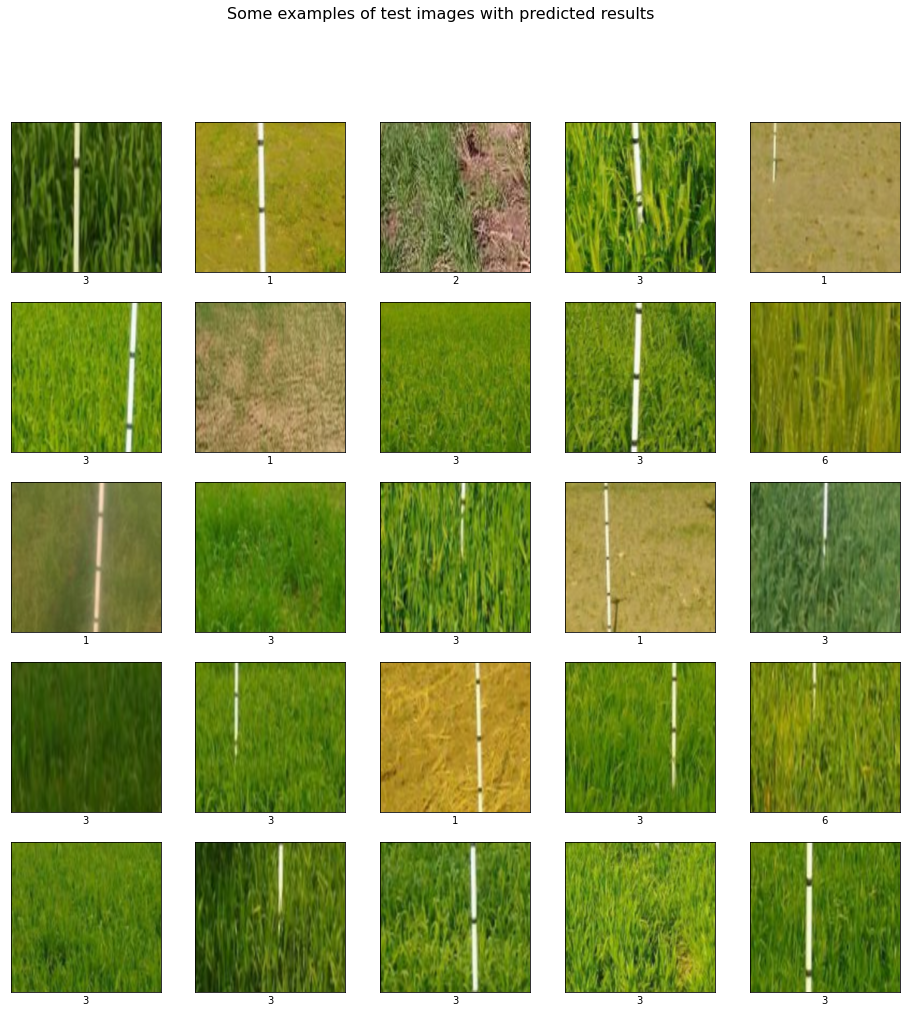

In [ ]:
samples, names = next(iter(testloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of test images with predicted results", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(final[i])
plt.show()

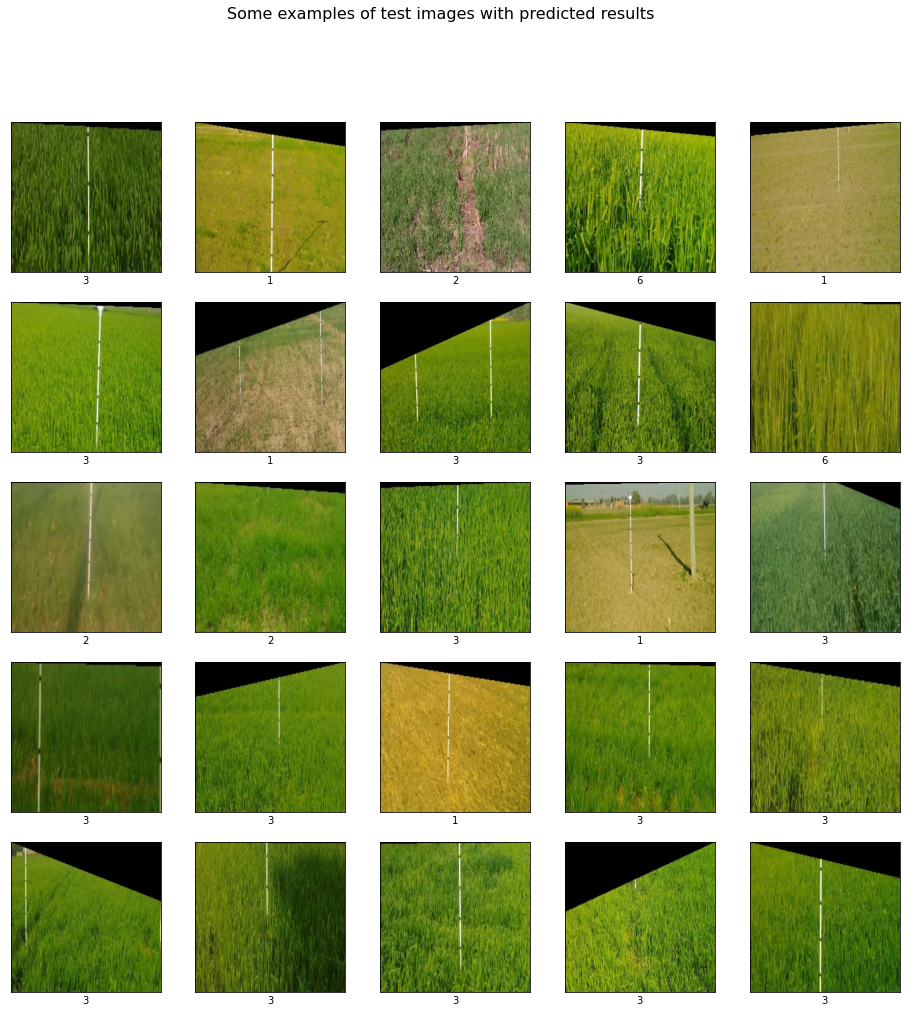

In [ ]:
samples, names = next(iter(testloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of test images with predicted results", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(final[i])
plt.show()

In [ ]:
submission = pd.DataFrame({'image_name': test_names_list, 'label': final})
submission.to_csv('submission_final.csv', index=False)
print('Submission file is created!')

Submission file is created!
